### Load dataset from build-in split

In [1]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

import matplotlib.pyplot as plt

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = './Dataset/'

history_length = 2
prediction_length = 6

# Use v1.0-trainval or v1.0-mini
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [13]:
# train = get_prediction_challenge_split("train", dataroot=DATAROOT)
# validation = get_prediction_challenge_split("train_val", dataroot=DATAROOT)
# test = get_prediction_challenge_split("val", dataroot=DATAROOT)

### Load dataset from custom split

In [2]:
import json

with open("./CustomDataSplit/moto.json", "r") as read_file:
    train = json.load(read_file)
    
with open("./CustomDataSplit/bikes.json", "r") as read_file:
    validation = json.load(read_file)
    
with open("./CustomDataSplit/peds.json", "r") as read_file:
    test = json.load(read_file)

In [3]:
print(f"Split: {len(train)} {len(validation)} {len(test)}")

Split: 1601 1277 8183


In [8]:
train = train[:1600]
validation = validation[:1200]
test = test[:3100]

In [9]:
print(f"Split: {len(train)} {len(validation)} {len(test)}")

Split: 1600 1200 3100


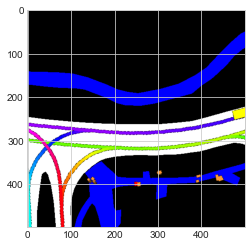

500 500 3


In [10]:
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

# Input representation
def GenerateImage(instance_token, sample_token):
    static_layer_rasterizer = StaticLayerRasterizer(helper)
    agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)

    mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

    img = mtp_input_representation.make_input_representation(instance_token, sample_token)

    return img


target_instance_token, start_prediction_sample_token = test[1550].split("_")

img = GenerateImage(target_instance_token, start_prediction_sample_token)
plt.imshow(img)
plt.show()

print(len(img), len(img[0]), len(img[0][0]))

In [11]:
import numpy as np
import torch

# NaN Values processing
def agent_param_processing(value):
    if np.isnan(value):
        return -1
    return value

vel = helper.get_velocity_for_agent(target_instance_token, start_prediction_sample_token)
vel = agent_param_processing(vel)

accel = helper.get_acceleration_for_agent(target_instance_token, start_prediction_sample_token)
accel = agent_param_processing(accel)

heading_cr = helper.get_heading_change_rate_for_agent(target_instance_token, start_prediction_sample_token)
heading_cr = agent_param_processing(heading_cr)

agent_state_vector = torch.Tensor([vel, accel, heading_cr])
agent_state_vector

tensor([0., 0., 0.])

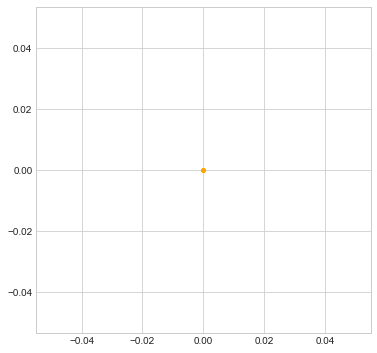

In [12]:
import matplotlib.pyplot as plt

def PlotPathWithPrediction(future, predict=[]):
    plt.figure(figsize=(6, 6))

    plt.scatter(future[:, 1], -future[:, 0], c='orange', s=10)
    
    if len(predict) > 0:
        plt.scatter(predict[:, 1], -predict[:, 0], c='g', s=10)

    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()


gt = helper.get_future_for_agent(target_instance_token, start_prediction_sample_token, prediction_length, in_agent_frame=True)
    
PlotPathWithPrediction(gt)

Make cycle for small amout of data. Creating dataframe

In [13]:
import numpy as np
from enum import Enum

np.set_printoptions(threshold=500*500*3)

class DatasetColumns(Enum):
    FEATURES = 1
    STATES = 2
    LABELS = 3
    
# NaN Values processing
def agent_param_processing(value):
    if np.isnan(value):
        return -1
    return value

In [14]:
from tqdm import tqdm

NPY_DATAROOT = './NpyDataset/'

def ConvertBatchToNpy(data, filename, dataToConvert, batch_indx=''):
    
    if dataToConvert == DatasetColumns.FEATURES:
        dataset_to_npy = np.empty([len(data), 500*500*3], dtype=np.uint8)
    
    if dataToConvert == DatasetColumns.STATES:
        dataset_to_npy = np.empty([len(data), 3])

    if dataToConvert == DatasetColumns.LABELS:
        dataset_to_npy = np.empty([len(data), 2*2*prediction_length])
    
    for i, x in enumerate(tqdm(dataset_to_npy)):
        instance_token, sample_token = data[i].split("_")
        
        if dataToConvert == DatasetColumns.FEATURES:
            # Take x
            img = GenerateImage(instance_token, sample_token)
            row = img.flatten()
            
        if dataToConvert == DatasetColumns.STATES:
            
            vel = helper.get_velocity_for_agent(instance_token, sample_token)
            vel = agent_param_processing(vel)

            accel = helper.get_acceleration_for_agent(instance_token, sample_token)
            accel = agent_param_processing(accel)

            heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
            heading_cr = agent_param_processing(heading_cr)
                
            row = np.array([vel, accel, heading_cr])
        
        if dataToConvert == DatasetColumns.LABELS:
            # Take y
            gt = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)
            row = gt.flatten()
            
        dataset_to_npy[i] = row
        
    np.save(f"{NPY_DATAROOT}{filename}.npy", dataset_to_npy)

In [15]:
# Сохраняет по батчам
batch_size = 256

def NpySamplesSaver(data, filename, dataToConvert):
    for i in range(int(len(data) / batch_size) + 1):
        
        from_sample = i * batch_size
        to_sample = min((i + 1) * batch_size, len(data))
        
        print(f"[{i}]{from_sample}:{to_sample}")
        
        batch = data[from_sample : to_sample]
        ConvertBatchToNpy(batch, filename, dataToConvert, i)

Train

In [9]:
amount_of_rows = 5000

In [16]:
NpySamplesSaver(train, 'multiagent_moto_1600', DatasetColumns.FEATURES)

  0%|          | 0/256 [00:00<?, ?it/s]

[0]0:256


  0%|          | 0/256 [00:00<?, ?it/s]

[1]256:512


  0%|          | 0/256 [00:00<?, ?it/s]

[2]512:768


  0%|          | 0/256 [00:00<?, ?it/s]

[3]768:1024


  0%|          | 0/256 [00:00<?, ?it/s]

[4]1024:1280


  0%|          | 0/256 [00:00<?, ?it/s]

[5]1280:1536


  0%|          | 0/64 [00:00<?, ?it/s]

[6]1536:1600


100%|██████████| 64/64 [09:00<00:00,  8.45s/it] 


In [19]:
ConvertBatchToNpy(train[:amount_of_rows], 'multiagent_train_states_5k', DatasetColumns.STATES)

100%|██████████| 5000/5000 [00:01<00:00, 2959.19it/s]


In [20]:
ConvertBatchToNpy(train[:amount_of_rows], 'multiagent_train_labels_5k', DatasetColumns.LABELS)

100%|██████████| 5000/5000 [00:00<00:00, 5433.58it/s]


Validation

In [12]:
amount_of_rows = 5000

In [18]:
NpySamplesSaver(validation, 'multiagent_bikes_1200', DatasetColumns.FEATURES)

  0%|          | 0/256 [00:00<?, ?it/s]

[0]0:256


 12%|█▎        | 32/256 [02:38<18:29,  4.95s/it]  


MemoryError: Unable to allocate 14.6 MiB for an array with shape (800, 800, 3) and data type float64

In [38]:
ConvertBatchToNpy(validation[:amount_of_rows], 'multiagent_validation_states_2k', DatasetColumns.STATES)

100%|██████████| 2000/2000 [00:00<00:00, 9191.83it/s]


In [39]:
ConvertBatchToNpy(validation[:amount_of_rows], 'multiagent_validation_labels_2k', DatasetColumns.LABELS)

100%|██████████| 2000/2000 [00:00<00:00, 11307.43it/s]


Test

In [16]:
amount_of_rows = 5000

In [17]:
NpySamplesSaver(test, 'multiagent_peds_3100', DatasetColumns.FEATURES)

  0%|          | 0/256 [00:00<?, ?it/s]

[0]0:256


  0%|          | 0/256 [00:00<?, ?it/s]

[1]256:512


  0%|          | 0/256 [00:00<?, ?it/s]

[2]512:768


  0%|          | 0/256 [00:00<?, ?it/s]

[3]768:1024


  0%|          | 0/256 [00:00<?, ?it/s]

[4]1024:1280


  0%|          | 0/256 [00:00<?, ?it/s]

[5]1280:1536


  0%|          | 0/256 [00:00<?, ?it/s]

[6]1536:1792


  0%|          | 0/256 [00:00<?, ?it/s]

[7]1792:2048


  0%|          | 0/256 [00:00<?, ?it/s]

[8]2048:2304


  0%|          | 0/256 [00:00<?, ?it/s]

[9]2304:2560


  0%|          | 0/256 [00:00<?, ?it/s]

[10]2560:2816


  0%|          | 0/256 [00:00<?, ?it/s]

[11]2816:3072


  0%|          | 0/28 [00:00<?, ?it/s]

[12]3072:3100


100%|██████████| 28/28 [03:54<00:00,  8.38s/it]


In [40]:
ConvertBatchToNpy(test[:amount_of_rows], 'multiagent_test_states_2k', DatasetColumns.STATES)

100%|██████████| 2000/2000 [00:00<00:00, 5221.71it/s]


In [41]:
ConvertBatchToNpy(test[:amount_of_rows], 'multiagent_test_labels_2k', DatasetColumns.LABELS)

100%|██████████| 2000/2000 [00:00<00:00, 9251.91it/s] 


Try to read data and check

In [79]:
import numpy as np

loaded_img = np.load(f'{NPY_DATAROOT}multiagent_test_features_2k.npy')
loaded_states = np.load(f'{NPY_DATAROOT}multiagent_test_states_2k.npy')
loaded_labels = np.load(f'{NPY_DATAROOT}multiagent_test_labels_2k.npy')

In [80]:
len(loaded_img), len(loaded_states), len(loaded_labels)

(2000, 2000, 2000)

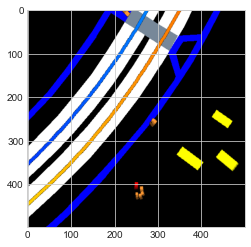

In [102]:
index_to_check = 1550

img = loaded_img[index_to_check]
img = img.reshape((500, 500, 3))

plt.imshow(img)
plt.show()

In [103]:
state = loaded_states[index_to_check]
state

array([0.89730438, 0.06718071, 0.03872622])

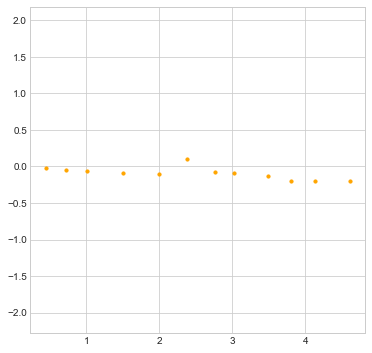

In [104]:
gt = loaded_labels[index_to_check]
gt = gt.reshape((12, 2))

PlotPathWithPrediction(gt)

### Try generate dataset with GPU acceleration

In [ ]:
import torch

print(torch.cuda.is_available())

device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on ', device)
print(f"Device count: {torch.cuda.device_count()}")

In [ ]:
from tqdm import tqdm

NPY_DATAROOT = './NpyDataset/'


def ConvertSamplesToNpyTensors(data, filename):
    
    dataset_to_npy = np.empty([len(data), 500*500*3], dtype=np.uint8)
    dataset_to_npy = torch.from_numpy(dataset_to_npy).to(device0)
    
    for i, x in enumerate(tqdm(dataset_to_npy)):
        instance_token, sample_token = data[i].split("_")
        
        # Take x
        img = GenerateImage(instance_token, sample_token)
        row = img.flatten()
        row = torch.tensor(row).to(device0)

        dataset_to_npy[i] = row
     
    torch.save(dataset_to_npy, f"{NPY_DATAROOT}{filename}")

In [32]:
loaded_tesnor = torch.load(f"{NPY_DATAROOT}{'img_tensor.pt'}")

In [34]:
loaded_tesnor.size()

torch.Size([2000, 750000])

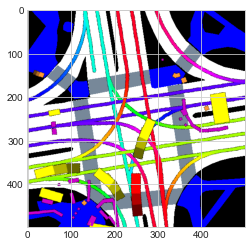

In [38]:
img = loaded_tesnor[29].reshape((500, 500, 3)).cpu().numpy()

plt.imshow(img)
plt.show()

Generate agent's tensors